In [118]:
import pandas as pd
import numpy as np
import os
import json
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")
print("BERT ESG Analysis Setup Complete")
print("=" * 50)

Using device: CPU
BERT ESG Analysis Setup Complete


In [119]:
# 1. Load and Prepare ESG Data

def load_benchmark_scores():
    """Load benchmark ESG scores from benchMark.md"""
    benchmark_scores = {
        'Nike': 70, 'Apple': 70, 'Boeing': 79, 'Disney': 68, 'Eli Lilly': 64, 'FedEx': 71,
        'Johnson & Johnson': 85, 'JPMorgan Chase': 80, 'McDonald\'s': 66, 'Meta': 60,
        'Microsoft': 87, 'Netflix': 37, 'NVIDIA': 77, 'Tesla': 72, 'Google': 81
    }
    return benchmark_scores

def load_company_documents():
    """Load all ESG-related documents for each company"""
    data_path = "data"
    company_texts = {}
    
    # Company directory mapping
    company_dirs = {
        'Nike': 'nike', 'Apple': 'apple', 'Boeing': 'boeing', 'Disney': 'disney',
        'Eli Lilly': 'elililly', 'FedEx': 'fedex', 'Johnson & Johnson': 'johnsonandjohnson',
        'JPMorgan Chase': 'jpmorganchase', 'McDonald\'s': 'mcdonald', 'Meta': 'meta',
        'Microsoft': 'microsoft', 'Netflix': 'netflix', 'NVIDIA': 'nvidia',
        'Tesla': 'tesla', 'Google': 'google'
    }
    
    print("Loading company documents...")
    for company, dir_name in company_dirs.items():
        company_path = os.path.join(data_path, dir_name)
        if os.path.exists(company_path):
            all_text = ""
            file_count = 0
            
            # Load all relevant files
            for file in os.listdir(company_path):
                if file.endswith(('.md', '.txt')):
                    file_path = os.path.join(company_path, file)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            content = f.read()
                            # Truncate very long documents for BERT processing
                            if len(content) > 50000:  # Limit for BERT processing
                                content = content[:50000]
                            all_text += content + " "
                            file_count += 1
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")
            
            if all_text.strip():
                company_texts[company] = all_text.strip()
                print(f"✓ {company}: {file_count} files, {len(all_text)} characters")
            else:
                print(f"✗ {company}: No text found")
        else:
            print(f"✗ {company}: Directory not found - {company_path}")
    
    return company_texts

# Load data
benchmark_scores = load_benchmark_scores()
company_texts = load_company_documents()

# Create dataset
data = []
for company in company_texts.keys():
    if company in benchmark_scores:
        data.append({
            'company': company,
            'text': company_texts[company],
            'esg_score': benchmark_scores[company]
        })

esg_df = pd.DataFrame(data)

Loading company documents...
✓ Nike: 5 files, 195218 characters
✓ Apple: 5 files, 132840 characters
✓ Boeing: 5 files, 170027 characters
✓ Disney: 5 files, 205533 characters
✓ Eli Lilly: 5 files, 200317 characters
✓ FedEx: 5 files, 205062 characters
✓ Johnson & Johnson: 5 files, 133248 characters
✓ JPMorgan Chase: 5 files, 141135 characters
✓ McDonald's: 5 files, 50248 characters
✓ Meta: 5 files, 196477 characters
✓ Microsoft: 5 files, 199364 characters
✓ Netflix: 5 files, 147484 characters
✓ NVIDIA: 5 files, 188603 characters
✓ Tesla: 5 files, 155647 characters
✓ Google: 5 files, 174319 characters


In [120]:
# 2. Create ESG Score Categories

def create_esg_categories(df):
    """Create categorical labels from continuous ESG scores"""
    
    # Create quartile-based categories
    df['esg_quartile'] = pd.qcut(df['esg_score'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    # Create three-tier categorization
    df['esg_tier'] = pd.cut(df['esg_score'], 
                           bins=[0, 50, 75, 100], 
                           labels=['Poor', 'Good', 'Excellent'],
                           include_lowest=True)
    
    # Create binary classification (above/below median)
    median_score = df['esg_score'].median()
    df['esg_binary'] = df['esg_score'].apply(lambda x: 'High' if x >= median_score else 'Low')
    
    return df

# Apply categorization
esg_df = create_esg_categories(esg_df)

In [121]:
# 3. BERT Embeddings Extraction

def setup_bert_embedder():
    """
    Setup BERT embedder following 
    """
    
    embedder = pipeline(
        model="answerdotai/ModernBERT-base",
        tokenizer="answerdotai/ModernBERT-base", 
        task="feature-extraction",
        device=device,
        return_tensors="pt",  
        truncation=True,
        padding=True,
        max_length=512  
    )
    model_name = "ModernBERT-base"
    
    return embedder, model_name

def get_bert_embeddings(texts, embedder):
    """
    Extract BERT embeddings
    Returns CLS token embeddings
    """
    print(f"Extracting BERT embeddings for {len(texts)} texts...")
    
    embeddings = []
    for i, text in enumerate(texts):
        try:
            if len(text) > 2000:
                text = text[:2000]
            
            # Get embeddings
            result = embedder(text)
            
            # Extract CLS token embedding (first token) - Handle different output formats
            cls_embedding = None
            
            if isinstance(result, list) and len(result) > 0:
                # Case 1: List of tensors/arrays
                first_element = result[0]
                if hasattr(first_element, 'shape') and len(first_element.shape) >= 2:
                    # Get first token ([CLS]) embedding: shape should be [seq_len, hidden_dim]
                    cls_embedding = first_element[0]  # First token
                elif hasattr(first_element, 'shape') and len(first_element.shape) == 3:
                    # Shape might be [batch, seq_len, hidden_dim]
                    cls_embedding = first_element[0][0]  # First batch, first token
            elif hasattr(result, 'shape'):
                # Case 2: Direct tensor/array
                if len(result.shape) == 2:
                    cls_embedding = result[0]  # First token
                elif len(result.shape) == 3:
                    cls_embedding = result[0][0]  # First batch, first token
            
            # Convert to numpy if needed
            if cls_embedding is not None:
                if hasattr(cls_embedding, 'numpy'):
                    cls_embedding = cls_embedding.numpy()
                elif hasattr(cls_embedding, 'detach'):
                    cls_embedding = cls_embedding.detach().numpy()
                embeddings.append(cls_embedding)
            else:
                print(f"Warning: Could not extract embedding for text {i}, using zero embedding")
                embeddings.append(np.zeros(768))  # Standard BERT embedding size
            
            if (i + 1) % 5 == 0:
                print(f"  Processed {i + 1}/{len(texts)} texts")
                
        except Exception as e:
            print(f"Error processing text {i}: {e}")
            # Use zero embedding as fallback
            embeddings.append(np.zeros(768))
    
    embeddings_array = np.array(embeddings)

    return embeddings_array

# Setup BERT embedder
embedder, model_name = setup_bert_embedder()

if embedder is not None:
    # Extract embeddings for all company texts
    company_texts_list = esg_df['text'].tolist()
    bert_embeddings = get_bert_embeddings(company_texts_list, embedder)
    
    # Add embeddings to dataframe
    esg_df['bert_embeddings'] = bert_embeddings.tolist()

Device set to use cpu


Extracting BERT embeddings for 15 texts...
  Processed 5/15 texts
  Processed 10/15 texts
  Processed 15/15 texts


In [122]:
# 4. Train-Test Split 

def prepare_bert_train_test_split(df, test_size=0.3, random_state=777):
    """
    Prepare train-test split for BERT embeddings
    """
    
    # Extract features and targets
    X = np.array(df['bert_embeddings'].tolist())  
    y_regression = df['esg_score'].values
    y_quartile = df['esg_quartile'].values
    y_tier = df['esg_tier'].values
    y_binary = df['esg_binary'].values
    companies = df['company'].values
    
    # Create splits
    X_train, X_test, y_reg_train, y_reg_test = train_test_split(
        X, y_regression, test_size=test_size, random_state=random_state
    )
    
    # Split other target variables maintaining same indices
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_state
    )
    
    y_quartile_train = y_quartile[train_indices]
    y_quartile_test = y_quartile[test_indices]
    
    y_tier_train = y_tier[train_indices]
    y_tier_test = y_tier[test_indices]
    
    y_binary_train = y_binary[train_indices]
    y_binary_test = y_binary[test_indices]
    
    companies_train = companies[train_indices]
    companies_test = companies[test_indices]
    
    return (X_train, X_test, 
            y_reg_train, y_reg_test,
            y_quartile_train, y_quartile_test,
            y_tier_train, y_tier_test,
            y_binary_train, y_binary_test,
            companies_train, companies_test)

# Create train-test split for BERT
if 'bert_embeddings' in esg_df.columns:
    (X_train, X_test, 
     y_reg_train, y_reg_test,
     y_quartile_train, y_quartile_test,
     y_tier_train, y_tier_test,
     y_binary_train, y_binary_test,
     companies_train, companies_test) = prepare_bert_train_test_split(esg_df)
    

In [123]:
# 5. Classification Models with BERT

def train_bert_classification_models(X_train, X_test, y_train, y_test, task_name):
    """
    Train classification models with BERT embeddings
    """
    
    results = {}
    
    # Logistic Regression
    lr_clf = LogisticRegression(max_iter=1000, random_state=777)
    lr_clf.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = lr_clf.predict(X_train)
    y_test_pred = lr_clf.predict(X_test)
    
    print("Logistic Regression Results:")
    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred))
    
    print("Test Set Performance:")
    print(classification_report(y_test, y_test_pred))
    
    results['LogisticRegression'] = {
        'model': lr_clf,
        'train_pred': y_train_pred,
        'test_pred': y_test_pred
    }
    
    # Random Forest 
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=777)
    rf_clf.fit(X_train, y_train)
    
    y_train_pred_rf = rf_clf.predict(X_train)
    y_test_pred_rf = rf_clf.predict(X_test)
    
    print("Random Forest Results:")
    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred_rf))
    
    print("Test Set Performance:")
    print(classification_report(y_test, y_test_pred_rf))
    
    results['RandomForest'] = {
        'model': rf_clf,
        'train_pred': y_train_pred_rf,
        'test_pred': y_test_pred_rf
    }
    
    return results

# Train classification models if BERT embeddings are available
if 'X_train' in locals():
    # Binary classification
    print("BINARY ESG CLASSIFICATION WITH BERT")
    binary_bert_results = train_bert_classification_models(
        X_train, X_test, y_binary_train, y_binary_test,
        "Binary ESG"
    )
    
    # Tier classification  
    tier_bert_results = train_bert_classification_models(
        X_train, X_test, y_tier_train, y_tier_test,
        "Tier ESG"
    )
else:
    print("Skipping classification - BERT embeddings not available")

BINARY ESG CLASSIFICATION WITH BERT
Logistic Regression Results:

Training Set Performance:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         6
         Low       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Test Set Performance:
              precision    recall  f1-score   support

        High       0.50      1.00      0.67         2
         Low       1.00      0.33      0.50         3

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5

Random Forest Results:

Training Set Performance:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         6
         Low       1.00      1.00      1.00         4

    accuracy      

In [124]:
# 6. Regression Models with BERT Embeddings

def train_bert_regression_models(X_train, X_test, y_train, y_test):
    """
    Train regression models with BERT embeddings for continuous ESG score prediction
    """
    
    print(f"\nESG Score Regression with BERT Embeddings")
    print("=" * 60)
    
    results = {}
    
    # Linear Regression 
    lr_reg = LinearRegression()
    lr_reg.fit(X_train, y_train)
    
    y_train_pred = lr_reg.predict(X_train)
    y_test_pred = lr_reg.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("Linear Regression:")
    print(f"  Training: MAE={train_mae:.2f}, R²={train_r2:.4f}")
    print(f"  Test: MAE={test_mae:.2f}, R²={test_r2:.4f}")
    
    results['LinearRegression'] = {
        'model': lr_reg,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_pred': y_train_pred,
        'test_pred': y_test_pred
    }
    
    # Ridge Regression
    ridge_reg = Ridge(alpha=1.0, random_state=777)
    ridge_reg.fit(X_train, y_train)
    
    y_train_pred_ridge = ridge_reg.predict(X_train)
    y_test_pred_ridge = ridge_reg.predict(X_test)
    
    train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
    test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
    train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
    test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
    
    print("Ridge Regression:")
    print(f"  Training: MAE={train_mae_ridge:.2f}, R²={train_r2_ridge:.4f}")
    print(f"  Test: MAE={test_mae_ridge:.2f}, R²={test_r2_ridge:.4f}")
    
    results['RidgeRegression'] = {
        'model': ridge_reg,
        'train_mae': train_mae_ridge,
        'test_mae': test_mae_ridge,
        'train_r2': train_r2_ridge,
        'test_r2': test_r2_ridge,
        'train_pred': y_train_pred_ridge,
        'test_pred': y_test_pred_ridge
    }
    
    # Random Forest Regression
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=777)
    rf_reg.fit(X_train, y_train)
    
    y_train_pred_rf = rf_reg.predict(X_train)
    y_test_pred_rf = rf_reg.predict(X_test)
    
    train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
    test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
    train_r2_rf = r2_score(y_train, y_train_pred_rf)
    test_r2_rf = r2_score(y_test, y_test_pred_rf)
    
    print("Random Forest Regression:")
    print(f"  Training: MAE={train_mae_rf:.2f}, R²={train_r2_rf:.4f}")
    print(f"  Test: MAE={test_mae_rf:.2f}, R²={test_r2_rf:.4f}")
    
    results['RandomForestRegression'] = {
        'model': rf_reg,
        'train_mae': train_mae_rf,
        'test_mae': test_mae_rf,
        'train_r2': train_r2_rf,
        'test_r2': test_r2_rf,
        'train_pred': y_train_pred_rf,
        'test_pred': y_test_pred_rf
    }
    
    return results

In [125]:
# 7. Comprehensive Evaluation Against Benchmark

def evaluate_bert_against_benchmark():
    """
    Use the best performing BERT model to predict ESG scores for all companies
    and evaluate against benchmark scores
    """
    
    print("\nEVALUATING BERT MODEL AGAINST BENCHMARK")
    print("=" * 60)
    
    # Check if BERT regression results are available
    if 'bert_reg_results' not in globals():
        print("Error: BERT regression results not available")
        return None, None, None, None, None, None
    
    # Find best model based on test R² score
    best_model_type = None
    best_r2 = -float('inf')
    best_model = None
    
    global bert_reg_results
    for model_name, results in bert_reg_results.items():
        if results['test_r2'] > best_r2:
            best_r2 = results['test_r2']
            best_model_type = model_name
            best_model = results['model']
    
    print(f"Best BERT model: {best_model_type}")
    print(f"Best test R²: {best_r2:.4f}")
    
    # Predict for all companies using BERT embeddings
    all_embeddings = np.array(esg_df['bert_embeddings'].tolist())
    all_companies = esg_df['company'].tolist()
    actual_scores = esg_df['esg_score'].tolist()
    
    # Get predictions from best model
    predicted_scores = best_model.predict(all_embeddings)
    
    # Create evaluation dataframe
    evaluation_data = []
    for i, company in enumerate(all_companies):
        evaluation_data.append({
            'Company': company,
            'Benchmark_Score': actual_scores[i],
            'BERT_Predicted': predicted_scores[i],
            'Error': predicted_scores[i] - actual_scores[i],
            'Abs_Error': abs(predicted_scores[i] - actual_scores[i])
        })
    
    eval_df = pd.DataFrame(evaluation_data)
    eval_df = eval_df.sort_values('Benchmark_Score')
    
    # Calculate overall metrics
    mae_overall = mean_absolute_error(eval_df['Benchmark_Score'], eval_df['BERT_Predicted'])
    rmse_overall = np.sqrt(mean_squared_error(eval_df['Benchmark_Score'], eval_df['BERT_Predicted']))
    r2_overall = r2_score(eval_df['Benchmark_Score'], eval_df['BERT_Predicted'])
    
    print(f"\nOVERALL PERFORMANCE METRICS:")
    print(f"Mean Absolute Error (MAE): {mae_overall:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse_overall:.2f}")
    print(f"R² Score: {r2_overall:.4f}")
    
    print(f"\nDETAILED RESULTS FOR ALL 15 COMPANIES:")
    print(eval_df.round(2))
    
    # Performance analysis
    accurate_predictions = eval_df[eval_df['Abs_Error'] <= 10]
    poor_predictions = eval_df[eval_df['Abs_Error'] > 20]
    
    print(f"\nPERFORMANCE ANALYSIS:")
    print(f"Accurate predictions (±10 points): {len(accurate_predictions)}/{len(eval_df)} companies")
    print(f"Poor predictions (>20 points error): {len(poor_predictions)}/{len(eval_df)} companies")
    
    if len(poor_predictions) > 0:
        print(f"Companies with poor predictions: {', '.join(poor_predictions['Company'].tolist())}")
    
    # Save results
    eval_df.to_csv('bert_evaluation_results.csv', index=False)
    print(f"\nResults saved to: bert_evaluation_results.csv")
    
    return eval_df, mae_overall, rmse_overall, r2_overall, best_model_type, model_name

# Run evaluation if BERT models are available

bert_eval_df, bert_mae_overall, bert_rmse_overall, bert_r2_overall, bert_best_model_type, bert_model_name = evaluate_bert_against_benchmark()


EVALUATING BERT MODEL AGAINST BENCHMARK
Best BERT model: RandomForestRegression
Best test R²: -0.7776

OVERALL PERFORMANCE METRICS:
Mean Absolute Error (MAE): 4.10
Root Mean Square Error (RMSE): 4.78
R² Score: 0.8368

DETAILED RESULTS FOR ALL 15 COMPANIES:
              Company  Benchmark_Score  BERT_Predicted  Error  Abs_Error
11            Netflix               37           47.04  10.04      10.04
9                Meta               60           64.84   4.84       4.84
4           Eli Lilly               64           66.66   2.66       2.66
8          McDonald's               66           66.81   0.81       0.81
3              Disney               68           72.96   4.96       4.96
0                Nike               70           76.82   6.82       6.82
1               Apple               70           70.44   0.44       0.44
5               FedEx               71           74.38   3.38       3.38
13              Tesla               72           72.95   0.95       0.95
12          

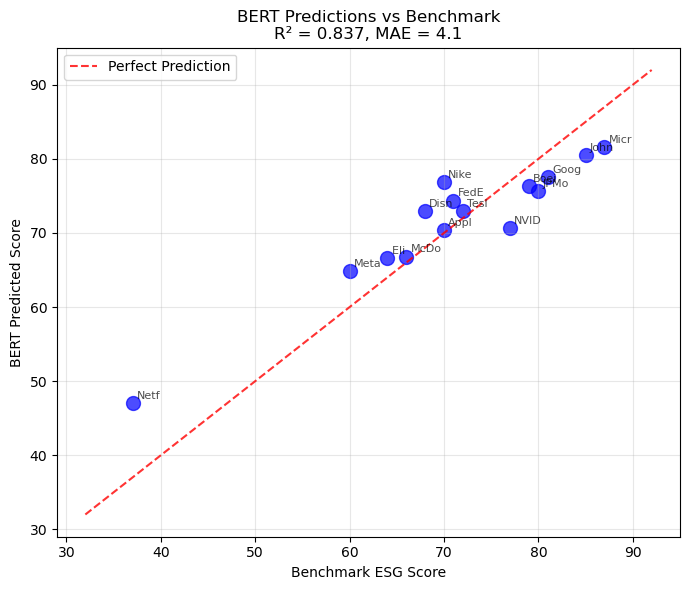

In [126]:
# Visualization: Predicted vs Actual Scores Only

def plot_bert_predicted_vs_actual():
    """
    Plot BERT predicted ESG scores vs benchmark scores
    """
    if 'bert_eval_df' not in locals() and 'bert_eval_df' not in globals():
        print("No BERT evaluation results to visualize")
        return

    plt.figure(figsize=(7, 6))
    plt.scatter(bert_eval_df['Benchmark_Score'], bert_eval_df['BERT_Predicted'], alpha=0.7, s=100, color='blue')

    # Perfect prediction line
    min_score = min(bert_eval_df['Benchmark_Score'].min(), bert_eval_df['BERT_Predicted'].min()) - 5
    max_score = max(bert_eval_df['Benchmark_Score'].max(), bert_eval_df['BERT_Predicted'].max()) + 5
    plt.plot([min_score, max_score], [min_score, max_score], 'r--', alpha=0.8, label='Perfect Prediction')

    plt.xlabel('Benchmark ESG Score')
    plt.ylabel('BERT Predicted Score')
    plt.title(f'BERT Predictions vs Benchmark\nR² = {bert_r2_overall:.3f}, MAE = {bert_mae_overall:.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add company labels
    for _, row in bert_eval_df.iterrows():
        plt.annotate(row['Company'][:4], (row['Benchmark_Score'], row['BERT_Predicted']),
                     xytext=(3, 3), textcoords='offset points', fontsize=8, alpha=0.7)

    plt.tight_layout()
    plt.show()

# Plot if results are available
if 'bert_eval_df' in locals():
    plot_bert_predicted_vs_actual()
else:
    print("Skipping visualization - BERT evaluation results not available")
